In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from collections import Counter

sns.set_style("darkgrid")
sns.set_palette("pastel")

# ITSC-2181 Statistics
Fetches ITSC-2181 student data for statistical analysis.

## Configuration
Set each of these constants as appropriate

In [2]:
# CLT's Canvas LMS base url.
BASE_URL = "https://instructure.charlotte.edu"

# Course section ID.
#
# Find your section at https://instructure.charlotte.edu/api/v1/courses/261043/sections
COURSE_SECTION_ID = -1

# Canvas access token. https://learn.canvas.cornell.edu/canvas-api-access-tokens/
CANVAS_ACCESS_TOKEN = ""

# Pagination setting
RESULTS_PER_PAGE = 100

# Student IDs to filter from results, like test students.
IGNORE_STUDENT_IDS = [424752]

Basic config error checking

In [3]:
if CANVAS_ACCESS_TOKEN == "":
    raise Exception("You need a canvas access token to run this script. Please set CANVAS_ACCESS_TOKEN in the configuration section of this notebook.")
if COURSE_SECTION_ID == -1:
    raise Exception("You need to set the section ID for your section. Please set COURSE_SECTION_ID in the configuration section of this notebook.")

Define some helper functions

In [4]:
headers = {
    "Authorization": f"Bearer {CANVAS_ACCESS_TOKEN}"
}

url = f"{BASE_URL}/api/v1/sections/{COURSE_SECTION_ID}"


def get_submissions(assignment_id):
    
    response = requests.get(url + f"/assignments/{assignment_id}/submissions", headers=headers, params={"per_page": RESULTS_PER_PAGE})
    submissions = response.json()
    submissions = [s for s in submissions if s['user_id'] not in IGNORE_STUDENT_IDS]
    return submissions

def get_enrollments():
    params = {
        "per_page": RESULTS_PER_PAGE
    }

    response = requests.get(url + "/enrollments", headers=headers, params=params)
    enrollments = response.json()
    enrollments = [e for e in enrollments if e['user_id'] not in IGNORE_STUDENT_IDS]
    return enrollments

Fetch initial data to be used.

### Overall Grades

#### By Score

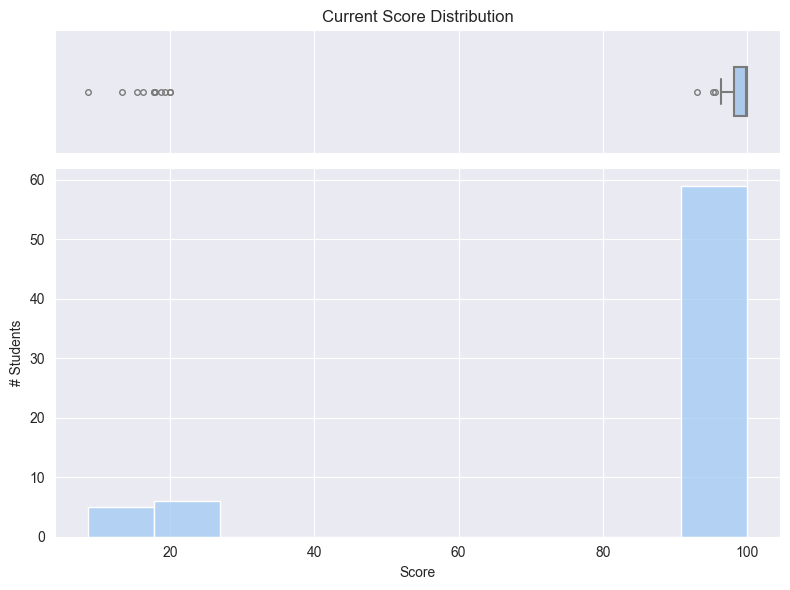

In [5]:
# Extract grade scores from enrollments
scores = list(map(lambda s : s.get("grades", {}).get("current_score"), get_enrollments()))
# Drop any None values
scores = [score for score in scores if score is not None]

# Box plot on top, histogram below
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios":[1,3]})

# Box plot
sns.boxplot(
    x=scores,
    ax=ax_box,
    width=0.4,
    fliersize=4,
    linewidth=1.5,

)
ax_box.set(title='Current Score Distribution')
ax_box.set_yticks([])  # remove y-axis labels

# Histogram
sns.histplot(
    scores,
    bins=10,
    ax=ax_hist,
)
ax_hist.set(xlabel='Score', ylabel='# Students')

plt.tight_layout()

plt.show()

#### By Letter

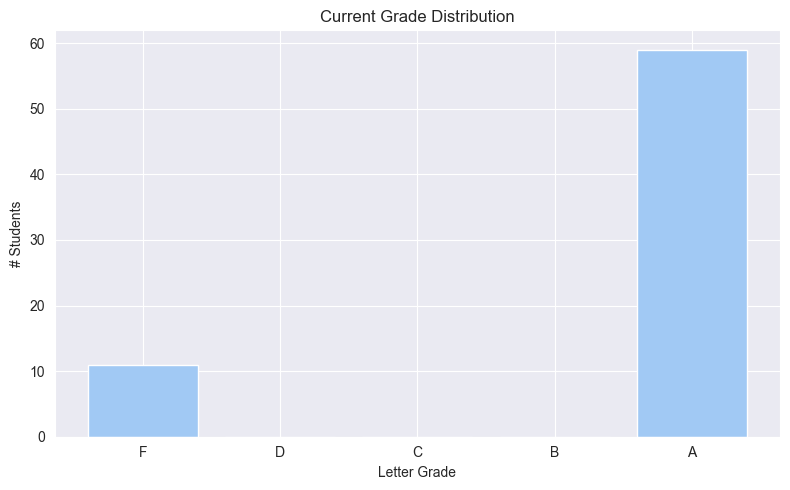

In [6]:
# Extract letter grades from enrollments
grades = [
    s.get("grades", {}).get("current_grade")
    for s in get_enrollments()
]

# Drop None or empty values
grades = [g for g in grades if g]

# Define desired grade order
grade_order = ["F", "D", "C", "B", "A"]

# Count grades
grade_counts = Counter(grades)

# Ensure all grades appear (even if count is 0)
counts = [grade_counts.get(g, 0) for g in grade_order]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(grade_order, counts)
ax.set(
    title="Current Grade Distribution",
    xlabel="Letter Grade",
    ylabel="# Students"
)

plt.tight_layout()
plt.show()

### Exercises

#### By Score

### Labs

In [18]:
def to_lab_score(score):
    match score:
        case 0.0: return 'Lacks Understanding/No Submission'
        case 5.0: return 'Developing Understanding'
        case 10.0: return 'Demonstrates Understanding'
        case _: return 'Abnormal Score'

#### Lab 0 (Checkoff Process and Expectations)

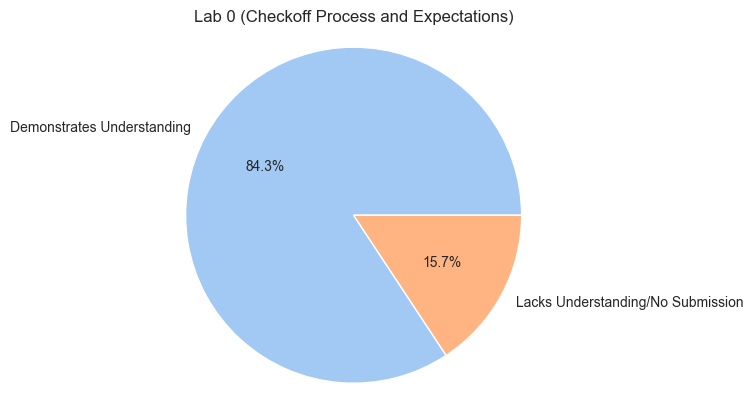

In [20]:
ASSIGNMENT_ID = 2798871

submissions = get_submissions(ASSIGNMENT_ID)
grades = [to_lab_score(s['score']) for s in submissions]

counts = Counter(grades)
labels = list(counts.keys())
sizes = list(counts.values())

plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Lab 0 (Checkoff Process and Expectations)")

plt.show()

### Projects

### Quizzes

### Final Exam